In [1]:
import pandas as pd
from sgs import SGS, series
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sgs = SGS()

In [3]:
bovespa = sgs.get_valores_series(7, '29/12/1989', '04/02/2019')

In [4]:
bovespa.columns=['DATA', 'BOVESPA']
bovespa = bovespa.set_index('DATA')
bovespa.head()

,BOVESPA
DATA,
1989-12-29,61615.0
1990-01-02,63736.0
1990-01-03,67341.0
1990-01-04,71622.0
1990-01-05,75638.0


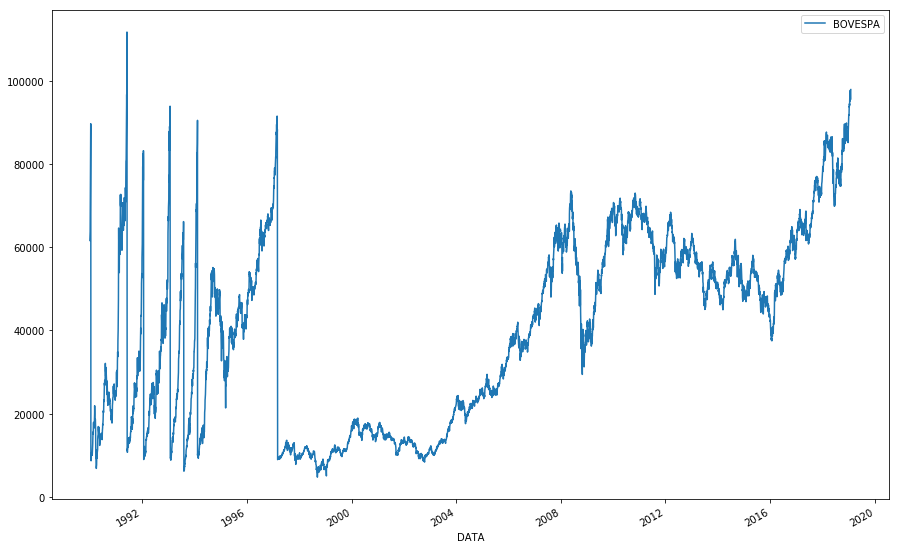

In [5]:
bovespa.plot(figsize=(15,10))

In [6]:
cdi = sgs.get_valores_series(12, '29/12/1989', '04/02/2019')

In [7]:
cdi.columns=['DATA', 'CDI']
cdi = cdi.set_index('DATA')
cdi.head()

,CDI
DATA,
1989-12-29,2.776528
1990-01-02,2.655806
1990-01-03,2.649278
1990-01-04,2.225639
1990-01-05,2.242583


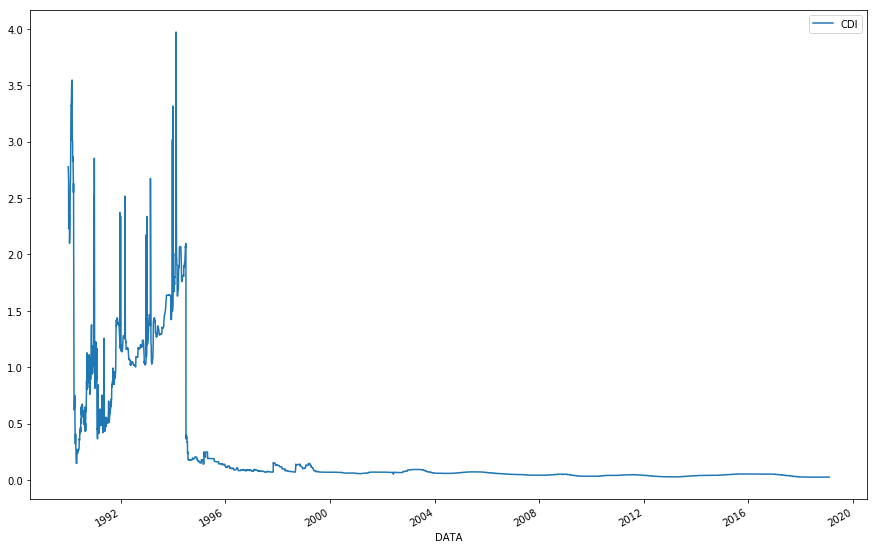

In [8]:
cdi.plot(figsize=(15,10))

In [9]:
cdi = cdi/100
cdi.head()

,CDI
DATA,
1989-12-29,0.027765
1990-01-02,0.026558
1990-01-03,0.026493
1990-01-04,0.022256
1990-01-05,0.022426


In [10]:
cdi_ajustado = ((cdi['CDI'])+1).cumprod()

In [11]:
cdi['CDI_ajustado'] = (cdi_ajustado/cdi_ajustado[0])

In [12]:
cdi = cdi.drop('CDI',axis=1)

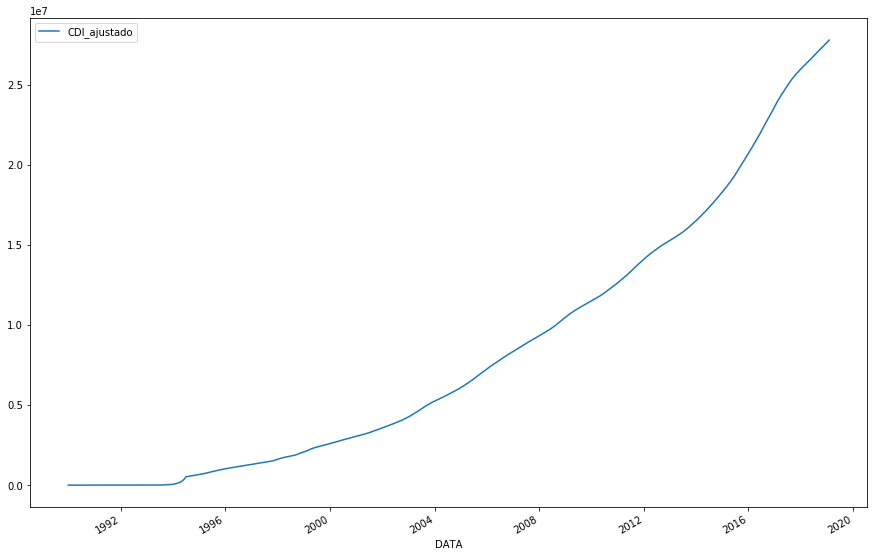

In [13]:
cdi.plot(figsize=(15,10))

In [14]:
data = bovespa.join(cdi)

In [15]:
data.head()

,BOVESPA,CDI_ajustado
DATA,,
1989-12-29,61615.0,1.000000
1990-01-02,63736.0,1.026558
1990-01-03,67341.0,1.053754
1990-01-04,71622.0,1.077207
1990-01-05,75638.0,1.101364


In [16]:
from pandas.tseries.offsets import BDay

In [17]:
def get_windows(df,n_years=30):
    years = [y+1 for y in range(n_years)]
    
    max_date = df.index.max()
    
    windows_dict = {}
    
    for y in years:
        
        start = df.index
        end = start.map(lambda x : x + y*252*BDay())
        
        windows_dict[y] = {
            'start': start,
            'end': end
        }
    
    return(windows_dict)

In [18]:
all_windows = get_windows(data)

In [19]:
def create_comparison_for_windows(data, windows):
    dfs = {}
    
    for window in windows:
        start_df = data.loc[all_windows[window]['start']]
        start_df = start_df.reset_index()
        start_df = start_df.add_suffix("_start")
        end_df = data.loc[all_windows[window]['end']]
        end_df = end_df.reset_index()
        end_df = end_df.add_suffix("_end")
        
        dfs[window] = start_df.join(end_df).dropna()
    
    return(dfs)

In [20]:
all_dfs = create_comparison_for_windows(data, all_windows)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [21]:
def analyze_windows(dfs, columns=['BOVESPA','CDI_ajustado']):
    
    for year in dfs: 
        for c in columns:
            dfs[year][c+'_diff'] = dfs[year][c+'_end'] - dfs[year][c+'_start']
            dfs[year][c+'_pct'] = (dfs[year][c+'_end']/dfs[year][c+'_start'])-1    
            
        dfs[year]['winner'] = dfs[year].filter(regex='_pct').idxmax(axis=1)
    
    return(dfs)

In [22]:
all_dfs_analyzed = analyze_windows(all_dfs)

In [23]:
all_dfs_analyzed[1]

,DATA_start,BOVESPA_start,CDI_ajustado_start,DATA_end,BOVESPA_end,CDI_ajustado_end,BOVESPA_diff,BOVESPA_pct,CDI_ajustado_diff,CDI_ajustado_pct,winner
0,1989-12-29,61615.0,1.000000e+00,1990-12-18,23246.0,1.298710e+01,-38369.0,-0.622722,1.198710e+01,11.987101,CDI_ajustado_pct
1,1990-01-02,63736.0,1.026558e+00,1990-12-20,25189.0,1.346576e+01,-38547.0,-0.604792,1.243921e+01,12.117392,CDI_ajustado_pct
2,1990-01-03,67341.0,1.053754e+00,1990-12-21,24972.0,1.379998e+01,-42369.0,-0.629171,1.274623e+01,12.096016,CDI_ajustado_pct
5,1990-01-08,82315.0,1.126204e+00,1990-12-26,24152.0,1.403366e+01,-58163.0,-0.706591,1.290746e+01,11.461033,CDI_ajustado_pct
6,1990-01-09,86796.0,1.151658e+00,1990-12-27,25526.0,1.419253e+01,-61270.0,-0.705908,1.304087e+01,11.323562,CDI_ajustado_pct
7,1990-01-10,89659.0,1.177507e+00,1990-12-28,25156.0,1.459734e+01,-64503.0,-0.719426,1.341984e+01,11.396821,CDI_ajustado_pct
10,1990-01-15,8699.0,1.261299e+00,1991-01-02,25321.0,1.473354e+01,16622.0,1.910794,1.347224e+01,10.681239,CDI_ajustado_pct
11,1990-01-16,8810.0,1.287758e+00,1991-01-03,28221.0,1.487385e+01,19411.0,2.203292,1.358609e+01,10.550192,CDI_ajustado_pct
12,1990-01-17,8926.0,1.315053e+00,1991-01-04,29853.0,1.500261e+01,20927.0,2.344499,1.368755e+01,10.408365,CDI_ajustado_pct
13,1990-01-18,9643.0,1.343258e+00,1991-01-07,30140.0,1.512448e+01,20497.0,2.125583,1.378122e+01,10.259550,CDI_ajustado_pct


In [24]:
results = []

for year in all_dfs_analyzed:
    #print('Window', year)
    temp_result = all_dfs_analyzed[year]['winner'].value_counts(normalize=True).round(4).to_dict()
    temp_result['window'] = year
    
    results.append(temp_result)

In [26]:
results_df = pd.DataFrame(results).fillna(0)

In [27]:
import os

path = 'data/'

if not(os.path.exists(path)):
    os.mkdir(path)

In [28]:
for year in all_dfs_analyzed:
    all_dfs_analyzed[year].to_csv(path+'/bovespa-x-cdi-window-'+str(year)+'.csv', index=False, float_format='%.4f')

In [29]:
results_df.to_csv(path+'/results.csv', index=False, float_format='%.4f')

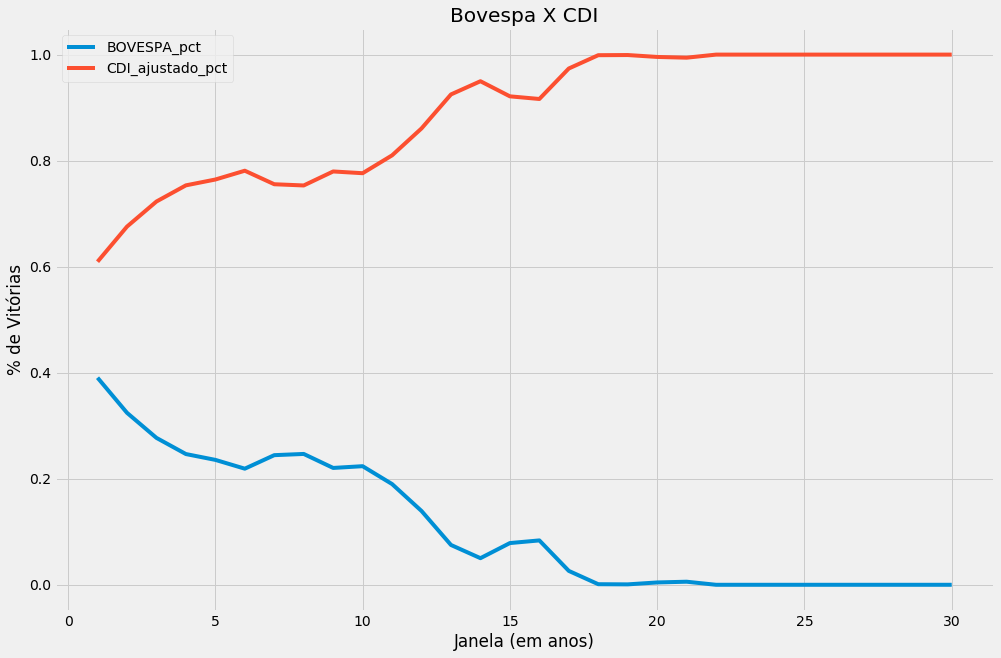

In [34]:
plt.style.use('fivethirtyeight')
ax = results_df.set_index('window').plot(figsize=(15,10), title='Bovespa X CDI')
ax.set_ylabel("% de Vitórias")
ax.set_xlabel("Janela (em anos)")
plt.savefig('data/bovespa-x-cdi.png')

In [31]:
results_df

,BOVESPA_pct,CDI_ajustado_pct,window
0,0.3906,0.6094,1
1,0.3244,0.6756,2
2,0.2771,0.7229,3
3,0.2466,0.7534,4
4,0.2356,0.7644,5
5,0.2190,0.7810,6
6,0.2445,0.7555,7
7,0.2468,0.7532,8
8,0.2204,0.7796,9
9,0.2237,0.7763,10
